## Football Match Outcome Prediction using Machine Learning

This notebook demonstrates a machine learning approach to predict the outcomes of football matches between national teams using historical match results and team rankings.


In [ ]:
!unzip euro2024-dataset.zip

In [180]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Step 1 - Load and preprocess data


In [181]:
# Define file paths
results_file = 'result_new.txt'
predict_file = 'predict.txt'
rankings_folder = 'rankings/'

In [182]:
# Helper function to estimate missing dates
def interpolate_dates(df):
    # Convert 'date' column to datetime format, coercing errors
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Sort DataFrame by 'date' column and reset index for consistency
    df = df.sort_values(by='date').reset_index(drop=True)

    # Linearly interpolate missing dates
    df['date'] = df['date'].interpolate(method='linear')

    # Forward fill and backward fill to handle any remaining missing dates
    df['date'] = df['date'].ffill().bfill()

    return df  # Return DataFrame with interpolated dates


 ### Handling Discrepancies in Match Results Input

#### Overview
The function `load_results` processes a text file containing football match results, extracting relevant information such as location, teams, scores, and dates. It addresses discrepancies that might arise from irregularities in the input format.

#### Steps Taken

1. **Extracting Location**:
   - The function checks each line for 'FT' to potentially extract the location using regex matching (`re.match(r'^FT(\w+)', lines[i])`).
   - If found, the location is associated with the subsequent match data.

2. **Reading Team Names and Scores**:
   - The function sequentially reads lines to capture home team name, score (splitting by '-'), and away team name.
   - It handles exceptions such as invalid score lines (`ValueError`, `IndexError`), skipping them if encountered.

3. **Adjusting Scores Based on Match Result**:
   - If the line indicates a match result involving penalties ('win on'), it adjusts scores accordingly.
   - This ensures that final scores reflect the actual outcome of the match.

4. **Parsing Match Date**:
   - Dates are extracted from lines and converted to a standardized format (`datetime.strptime(date_str, '%A %d/%m/%Y')`).
   - Invalid date formats are flagged and treated as `NaT` (Not a Time).

5. **Handling Missing or Inconsistent Location Data**:
   - The function maintains a dictionary (`locations`) to map teams to their respective locations as it processes the data.
   - If a location is missing for a match, it attempts to infer it based on historical data of the teams involved.

6. **Interpolating Missing Dates**:
   - After constructing the initial DataFrame (`df`), the function interpolates missing dates using historical match data.
   - This ensures that all matches have complete and accurate date information before sorting.



In [183]:
# Loading the results file and extracting match data
def load_results(file):
    # Open the file and read all lines into a list
    with open(file, 'r') as f:
        lines = f.readlines()

    data = []  # Initialize an empty list to store match data
    locations = {}  # Dictionary to map teams to their respective locations
    i = 0  # Initialize index to iterate through lines

    # Iterate through each line in the file
    while i < len(lines):
        location = None  # Initialize location variable

        # Check if the line contains 'FT' (indicating match result and possibly location)
        if 'FT' in lines[i]:
            # Extract location if present using regex matching
            match_location = re.match(r'^FT(\w+)', lines[i])
            if match_location:
                location = match_location.group(1)  # Extract location
                i += 1  # Move to the next line
            else:
                i += 1  # Skip the line containing 'FT' if no location found

        # Read home team name from current line
        if i < len(lines):
            home_team = lines[i].strip()  # Remove leading/trailing whitespace
            i += 1  # Move to the next line
        else:
            home_team = ""  # Set home team to empty string if no more lines

        # Read score line and extract home and away scores
        if i < len(lines):
            try:
                score_line = lines[i].strip()  # Remove leading/trailing whitespace
                score = score_line.split('-')  # Split score line by '-'
                home_score = int(score[0].strip())  # Extract home score
                away_score = int(score[1].strip())  # Extract away score
                i += 1  # Move to the next line
            except (ValueError, IndexError):
                print(f"Skipping invalid score line: {score_line}")
                i += 1  # Move to the next line if score line is invalid
                continue

        # Read away team name from current line
        if i < len(lines):
            away_team = lines[i].strip()  # Remove leading/trailing whitespace
            i += 1  # Move to the next line
        else:
            away_team = ""  # Set away team to empty string if no more lines

        # Adjust scores based on match result (win on penalties or regular time)
        if i < len(lines) and 'win on' in lines[i]:
            pattern = r'\((\d+) - (\d+)\)'  # Define pattern to match scores
            match = re.search(pattern, lines[i])  # Search for pattern in line
            if match:
                home_team_goals = int(match.group(1))  # Extract home team goals
                away_team_goals = int(match.group(2))  # Extract away team goals
                if home_team_goals > away_team_goals:
                    home_score += 1  # Increment home score if home team wins
                else:
                    away_score += 1  # Increment away score if away team wins
            i += 1  # Move to the next line

        # Read match date from current line and convert it to datetime format
        if i < len(lines):
            date_str = lines[i].strip()  # Remove leading/trailing whitespace
            try:
                date = datetime.strptime(date_str, '%A %d/%m/%Y')  # Parse date string
            except ValueError:
                print(f"Invalid date format for match {home_team} vs {away_team} on {date_str}. Marking date as NaT.")
                date = pd.NaT  # Set date to NaT (Not a Time) if format is invalid
            i += 1  # Move to the next line
        else:
            date = pd.NaT  # Set date to NaT if no more lines

        # Append match data to the list
        data.append([location, home_team, home_score, away_team, away_score, date])

        # Update location for home and away teams if available
        if location:
            locations[home_team] = location
            locations[away_team] = location

    # Create DataFrame from collected match data
    df = pd.DataFrame(data, columns=['location', 'home_team', 'home_score', 'away_team', 'away_score', 'date'])

    # Interpolate missing locations based on teams using historical data
    for idx, row in df.iterrows():
        if pd.isna(row['location']):
            if row['home_team'] in locations:
                df.at[idx, 'location'] = locations[row['home_team']]
            elif row['away_team'] in locations:
                df.at[idx, 'location'] = locations[row['away_team']]

    # Sort DataFrame by date and reset index for consistency
    df = interpolate_dates(df)
    df = df.sort_values(by='date').reset_index(drop=True)

    return df  # Return the cleaned and processed DataFrame containing match results


In [ ]:
results = load_results(results_file)

In [185]:
results.head()

,location,home_team,home_score,away_team,away_score,date
0,Couva,Panama,1,Peru,2,2013-06-02
1,Carson,USA,4,Germany,3,2013-06-03
2,Malmö,Sweden,1,FYR Macedonia,0,2013-06-04
3,Nanjing,Myanmar,0,Singapore,2,2013-06-05
4,Osaka,Denmark,2,Georgia,1,2013-06-06


In [186]:
results.isna().sum()

location      31
home_team      0
home_score     0
away_team      0
away_score     0
date           0
dtype: int64

### Handling Ranking Data Processing

#### Overview

This section describes the processing steps for ranking data used in predicting football match outcomes.


In [187]:
# Load rankings and process them
def load_rankings(folder):
    # Initialize an empty dictionary to store rankings data
    rankings_data = {}

    # Iterate over files in the specified folder, sorted by filename
    for file in sorted(os.listdir(folder)):
        # Extract date from filename assuming the format is ddmmyyyy
        date_str = os.path.basename(file)
        date = datetime.strptime(date_str, '%d%m%Y')

        # Read CSV file into a DataFrame
        df = pd.read_csv(os.path.join(folder, file))

        # Rename columns for clarity if needed
        df.columns = ['team', 'ranking1', 'ranking2', 'ranking3', 'ranking4']

        # Store DataFrame in rankings_data dictionary with date as key
        rankings_data[date] = df

    return rankings_data  # Return dictionary containing rankings data

In [188]:
rankings_data = load_rankings(rankings_folder)

#### 1. Compute Average Rankings (`compute_average_rankings`)

- **Purpose**:
  - Concatenates all ranking data from multiple sources into a single DataFrame.
  - Computes the average ranking for each team based on historical data.

- **Implementation**:
  - Concatenates ranking data from different sources into a unified DataFrame.
  - Calculates the mean ranking across different ranking metrics (`ranking1`, `ranking2`, `ranking3`, `ranking4`) for each team using `groupby`.


In [189]:
# Compute average rankings for each team
def compute_average_rankings(rankings_data):
    # Concatenate all DataFrames from rankings_data into a single DataFrame
    all_rankings = pd.concat(rankings_data.values())

    # Calculate mean rankings for each team using groupby
    team_averages = all_rankings.groupby('team').mean()

    return team_averages  # Return DataFrame with average rankings per team

In [190]:
team_averages = compute_average_rankings(rankings_data)

#### 2. Replace Zero Rankings with Average (`replace_zero_rankings_with_average`)

- **Purpose**:
  - Addresses missing or zero-ranking values for teams in historical data.
  - Substitutes zero rankings with the computed average ranking for each team.

- **Implementation**:
  - Iterates through ranking data for each date and checks for zero values in ranking columns.
  - Replaces zero values with the average ranking calculated in `compute_average_rankings`.


In [191]:
# Replace zero rankings with the average
def replace_zero_rankings_with_average(rankings_data, team_averages):
    for date, df in rankings_data.items():
        for col in ['ranking1', 'ranking2', 'ranking3', 'ranking4']:
            zero_mask = (df[col] == 0)
            df.loc[zero_mask, col] = df.loc[zero_mask, 'team'].map(team_averages[col])
    return rankings_data

In [192]:
rankings_data = replace_zero_rankings_with_average(rankings_data, team_averages)

#### 3. Determine Previous Ranking Date (`get_previous_ranking_date`)

- **Purpose**:
  - Identifies the most recent ranking date before or on a given match date.
  - Ensures that the model uses the closest available ranking data for match prediction.

- **Implementation**:
  - Compares match dates with available ranking dates and selects the latest ranking date before or on the match date.


In [193]:
# Function to find the most recent ranking date before or on the match date
def get_previous_ranking_date(match_date, rankings_data):
    # Get all available dates from rankings_data and sort them
    available_dates = sorted(rankings_data.keys())

    # Find dates in available_dates that are less than or equal to match_date
    previous_dates = [date for date in available_dates if date <= match_date]

    # If there are previous dates found, return the latest one
    if previous_dates:
        return previous_dates[-1]

    # Return None if no previous dates are found
    return None

#### 4. Add Rankings to Match Data (`add_rankings_to_matches`)

- **Purpose**:
  - Incorporates ranking information into the match dataset for feature engineering.
  - Enhances prediction accuracy by including team rankings as predictive features.

- **Implementation**:
  - Retrieves team rankings from the closest preceding ranking date using `get_previous_ranking_date`.
  - Computes mean rankings for home and away teams and adds them as new columns (`home_team_rank`, `away_team_rank`) to the match dataset.
  - Interpolates missing locations based on historical match data for consistency.


In [194]:
def add_rankings_to_matches(matches, rankings_data):
    # Initialize lists to store home and away team rankings
    home_team_rankings = []
    away_team_rankings = []

    # Iterate over each row (match) in the matches DataFrame
    for idx, row in matches.iterrows():
        # Get the match date from the current row
        match_date = row['date']

        # Find the closest ranking date before or on the match date
        closest_date = get_previous_ranking_date(match_date, rankings_data)

        # If a closest ranking date is found
        if closest_date:
            # Retrieve the rankings DataFrame for the closest date
            rankings = rankings_data[closest_date]

            try:
                # Try to find the home team's ranking and calculate mean if multiple columns are present
                home_ranking = rankings[rankings['team'] == row['home_team']].iloc[:, 1:].mean(axis=1).values[0]
            except IndexError:
                # Handle the case where no ranking is found for the home team
                print(f"No ranking found for {row['home_team']} on {closest_date}. Assigning NaN.")
                home_ranking = np.nan

            try:
                # Try to find the away team's ranking and calculate mean if multiple columns are present
                away_ranking = rankings[rankings['team'] == row['away_team']].iloc[:, 1:].mean(axis=1).values[0]
            except IndexError:
                # Handle the case where no ranking is found for the away team
                print(f"No ranking found for {row['away_team']} on {closest_date}. Assigning NaN.")
                away_ranking = np.nan
        else:
            # Handle the case where no previous ranking date is found for the match date
            print(f"No previous date found for match on {match_date}. Assigning NaN.")
            home_ranking = away_ranking = np.nan

        # Append the calculated rankings to the respective lists
        home_team_rankings.append(home_ranking)
        away_team_rankings.append(away_ranking)

    # Assign the calculated rankings to new columns in the matches DataFrame
    matches['home_team_rank'] = home_team_rankings
    matches['away_team_rank'] = away_team_rankings

    return matches

In [ ]:
results = add_rankings_to_matches(results, rankings_data)

In [196]:
results.head()

,location,home_team,home_score,away_team,away_score,date,home_team_rank,away_team_rank
0,Couva,Panama,1,Peru,2,2013-06-02,165.6775,188.2225
1,Carson,USA,4,Germany,3,2013-06-03,194.8125,357.0400
2,Malmö,Sweden,1,FYR Macedonia,0,2013-06-04,209.6125,110.3600
3,Nanjing,Myanmar,0,Singapore,2,2013-06-05,37.2100,33.2375
4,Osaka,Denmark,2,Georgia,1,2013-06-06,222.5275,97.7900


In [197]:
results.isna().sum()

location          31
home_team          0
home_score         0
away_team          0
away_score         0
date               0
home_team_rank    37
away_team_rank    41
dtype: int64

In [198]:
results.dropna(subset=['home_team_rank', 'away_team_rank'], inplace=True)

## Step 2 - Feature Engineering
### Feature Engineering for Football Match Prediction

#### Rank Difference (`rank_diff`):
- **Purpose**: Quantifies the disparity in rankings between the home and away teams.
- **Importance**: Higher-ranked teams tend to outperform lower-ranked ones. This feature helps gauge the relative strength between competing teams.

#### Home Team Win Indicator (`home_win`):
- **Purpose**: Directly encodes the match outcome (win/loss) for the home team.
- **Importance**: This serves as the target variable for supervised learning models. Predicting match outcomes is crucial for evaluating team performance and strategic decision-making.

#### Rank Ratio (`rank_ratio`) and Total Rank (`total_rank`):
- **Purpose**: Provides additional perspectives on team rankings.
- **Importance**: Rank ratio (home team rank divided by away team rank) highlights relative strength differences, while total rank (sum of home and away team ranks) captures the combined influence of rankings on match outcomes.

#### Home Advantage (`home_advantage`) and Neutral Location (`neutral_location`):
- **Purpose**: Incorporates location-based factors into the prediction model.
- **Importance**: Home advantage can significantly impact match outcomes due to factors like crowd support and venue familiarity. Neutral location identifies matches played on neutral ground, minimizing location bias.

#### Rolling Average of Scores (`home_team_rolling_avg` and `away_team_rolling_avg`):
- **Purpose**: Smooths out fluctuations in team performance over recent matches.
- **Importance**: Averages scores over a specified window (e.g., 5 matches), providing a trend of team performance. This helps capture momentum or decline in team form, which can influence match outcomes.

In [199]:
# Calculate rank difference between home and away teams
results['rank_diff'] = results['home_team_rank'] - results['away_team_rank']

# Determine if the home team won the match
results['home_win'] = results['home_score'] > results['away_score']

# Calculate rank ratio and total rank for each match
results['rank_ratio'] = results['home_team_rank'] / results['away_team_rank']
results['total_rank'] = results['home_team_rank'] + results['away_team_rank']

# Add new location-based features
results['home_advantage'] = results.apply(lambda row: int(row['location'] == row['home_team']), axis=1)
results['neutral_location'] = results.apply(lambda row: int(row['location'] not in [row['home_team'], row['away_team']]), axis=1)

# Calculate rolling averages for home and away teams over the last 5 matches
results['home_team_rolling_avg'] = results.groupby('home_team')['home_score'].transform(lambda x: x.rolling(5, 1).mean())
results['away_team_rolling_avg'] = results.groupby('away_team')['away_score'].transform(lambda x: x.rolling(5, 1).mean())

In [200]:
results.head()

,location,home_team,home_score,away_team,away_score,date,home_team_rank,away_team_rank,rank_diff,home_win,rank_ratio,total_rank,home_advantage,neutral_location,home_team_rolling_avg,away_team_rolling_avg
0,Couva,Panama,1,Peru,2,2013-06-02,165.6775,188.2225,-22.5450,False,0.880222,353.9000,0,1,1.0,2.0
1,Carson,USA,4,Germany,3,2013-06-03,194.8125,357.0400,-162.2275,True,0.545632,551.8525,0,1,4.0,3.0
2,Malmö,Sweden,1,FYR Macedonia,0,2013-06-04,209.6125,110.3600,99.2525,True,1.899352,319.9725,0,1,1.0,0.0
3,Nanjing,Myanmar,0,Singapore,2,2013-06-05,37.2100,33.2375,3.9725,False,1.119519,70.4475,0,1,0.0,2.0
4,Osaka,Denmark,2,Georgia,1,2013-06-06,222.5275,97.7900,124.7375,True,2.275565,320.3175,0,1,2.0,1.0


In [201]:
# Count the number of instances for each class in 'home_win'
class_counts = results['home_win'].value_counts()

# Calculate the proportion of each class
class_proportions = results['home_win'].value_counts(normalize=True)

print("Class Counts:")
print(class_counts)
print("\nClass Proportions:")
print(class_proportions)

Class Counts:
home_win
False    1850
True     1723
Name: count, dtype: int64

Class Proportions:
home_win
False    0.517772
True     0.482228
Name: proportion, dtype: float64


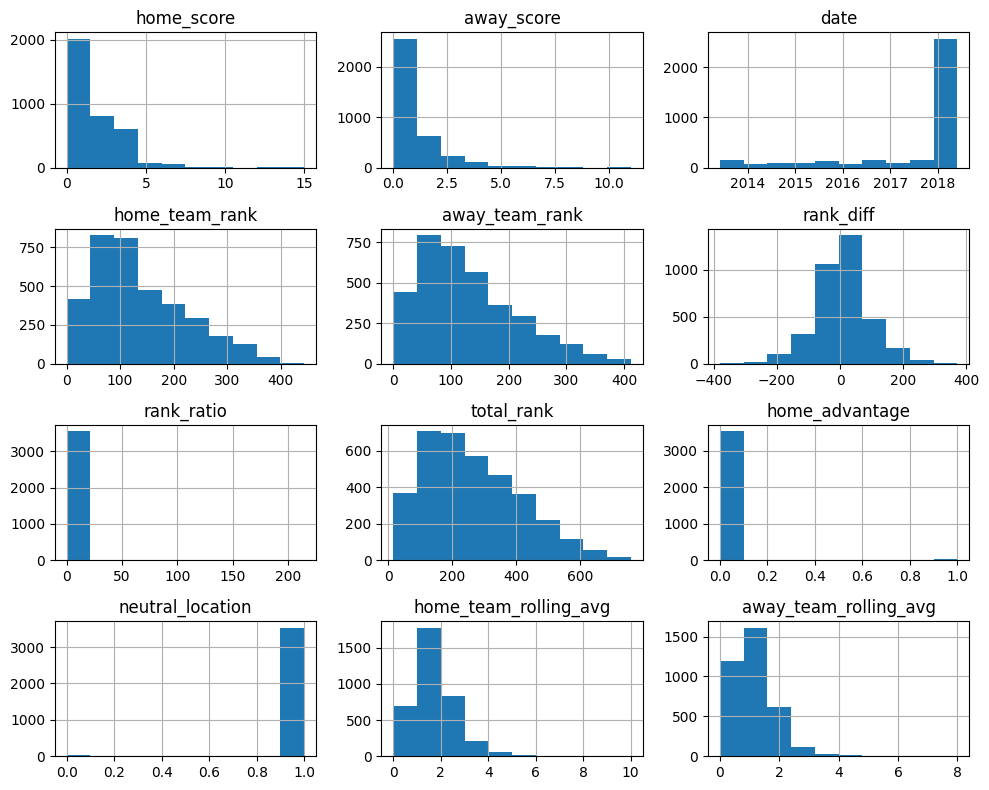

In [202]:
# Plot histograms of numerical features
results.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [203]:
# Create features and labels
X = results[['home_team_rank', 'away_team_rank', 'rank_diff', 'rank_ratio', 'total_rank', 'home_advantage', 'neutral_location', 'home_team_rolling_avg', 'away_team_rolling_avg']]
y = results['home_win']

In [204]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 3 - Create the Model

In [205]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Step 4 - Prediction and Evaluation
### Model Evaluation Metrics

1. **Confusion Matrix**:
   - The confusion matrix visualizes the performance of the model by showing the counts of true positives, true negatives, false positives, and false negatives.

2. **Accuracy Score**:
   - The accuracy score measures the proportion of correct predictions (both true positives and true negatives) out of all predictions made.

3. **F1 Score**:
   - The F1 score combines precision and recall into a single metric, providing a balanced assessment of the model's performance. It ranges from 0 to 1, where a higher score indicates better performance in terms of precision and recall.

#### Interpreting F1 Score:
- **High F1 Score**: Indicates strong precision and recall, reflecting accurate positive predictions and effective capture of positive instances.

  
- **Low F1 Score**: Indicates poor precision and/or recall, suggesting inaccurate positive predictions or failure to identify a significant number of positive instances.


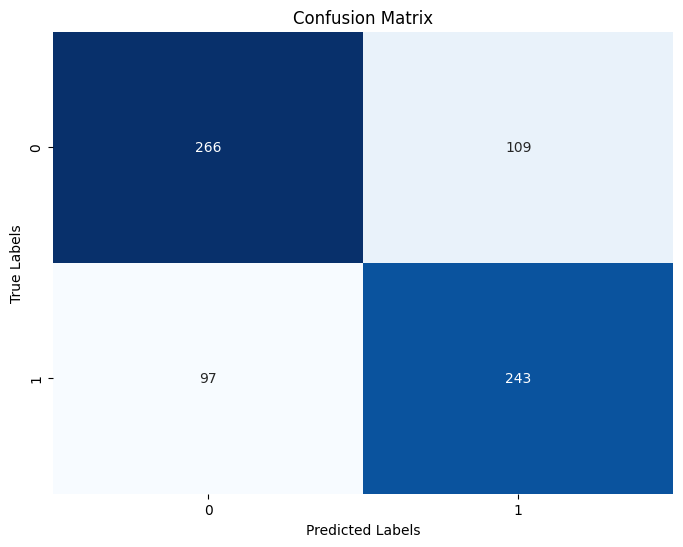

Accuracy Score: 0.71

F1 Score: 0.70


In [206]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"\nF1 Score: {f1:.2f}")

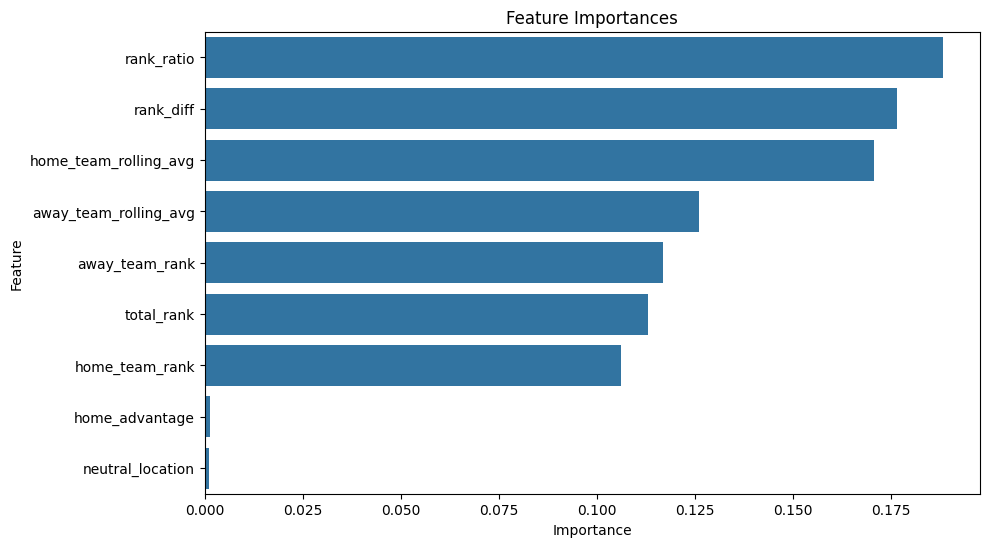

In [207]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [208]:
# Load prediction matches
predict = pd.read_csv(predict_file, header=None, names=['home_team', 'away_team'])

In [209]:

def add_rankings_to_predict(predict, rankings_data, results):
    """
    Function to add rankings, locations, estimated scores, and rolling averages to the predict DataFrame.

    Args:
    - predict (DataFrame): DataFrame containing match predictions with columns 'home_team' and 'away_team'.
    - rankings_data (dict): Dictionary where keys are dates and values are DataFrames containing team rankings.
    - results (DataFrame): DataFrame containing historical match results with columns 'home_team', 'away_team', 'home_score', 'away_score', and 'location'.

    Returns:
    - predict_features (DataFrame): DataFrame with added features including rankings, locations, and rolling averages.
    """

    # Initialize empty lists to store calculated rankings, locations, and estimated scores
    home_team_rankings = []
    away_team_rankings = []
    locations = []
    home_team_scores = []  # New list for estimated home scores
    away_team_scores = []  # New list for estimated away scores

    # Determine the latest date available in rankings_data
    latest_date = max(rankings_data.keys())
    rankings = rankings_data[latest_date]  # Extract rankings data for the latest date

    # Iterate over each row (match) in the predict DataFrame
    for idx, row in predict.iterrows():
        # Try to find and calculate the mean ranking for the home team
        try:
            home_ranking = rankings[rankings['team'] == row['home_team']].iloc[:, 1:].mean(axis=1).values[0]
        except IndexError:
            # Handle case where no ranking data is found for the home team
            print(f"No ranking found for {row['home_team']} on {latest_date}. Assigning NaN.")
            home_ranking = np.nan

        # Try to find and calculate the mean ranking for the away team
        try:
            away_ranking = rankings[rankings['team'] == row['away_team']].iloc[:, 1:].mean(axis=1).values[0]
        except IndexError:
            # Handle case where no ranking data is found for the away team
            print(f"No ranking found for {row['away_team']} on {latest_date}. Assigning NaN.")
            away_ranking = np.nan

        # Append calculated rankings to the respective lists
        home_team_rankings.append(home_ranking)
        away_team_rankings.append(away_ranking)

        # Try to infer the match location based on historical match data in results
        try:
            # Find the most recent match involving the home team
            recent_match_home = results[results['home_team'] == row['home_team']].iloc[-1]
            location = recent_match_home['location']
        except IndexError:
            try:
                # Find the most recent match involving the away team if no home match found
                recent_match_away = results[results['away_team'] == row['away_team']].iloc[-1]
                location = recent_match_away['location']
            except IndexError:
                # Handle case where no historical match data is found for either team
                print(f"No historical data found for {row['home_team']} or {row['away_team']}. Assigning NaN.")
                location = np.nan

        # Append inferred location to the locations list
        locations.append(location)

        # Estimate home_score and away_score based on historical averages or other data
        # Average home score for the home team
        try:
            avg_home_score = results[results['home_team'] == row['home_team']]['home_score'].mean()
            estimated_home_score = avg_home_score if not np.isnan(avg_home_score) else 0.8  # Default value if no data
        except IndexError:
            estimated_home_score = 0.8  # Default value if no historical data

        # Average away score for the away team
        try:
            avg_away_score = results[results['away_team'] == row['away_team']]['away_score'].mean()
            estimated_away_score = avg_away_score if not np.isnan(avg_away_score) else 1  # Default value if no data
        except IndexError:
            estimated_away_score = 1  # Default value if no historical data

        home_team_scores.append(estimated_home_score)
        away_team_scores.append(estimated_away_score)

        # Add estimated scores to predict DataFrame
        predict.loc[idx, 'home_team_score'] = estimated_home_score
        predict.loc[idx, 'away_team_score'] = estimated_away_score

        # Calculate rolling averages using estimated scores
        try:
            predict.loc[idx, 'home_team_rolling_avg'] = predict[predict['home_team'] == row['home_team']]['home_team_score'].rolling(5, min_periods=1).mean().iloc[-1]
            predict.loc[idx, 'away_team_rolling_avg'] = predict[predict['away_team'] == row['away_team']]['away_team_score'].rolling(5, min_periods=1).mean().iloc[-1]
        except KeyError:
            print("Warning: Columns 'home_team_score' and 'away_team_score' not found. Skipping rolling average calculations.")
            pass

    # Assign calculated rankings, locations, and estimated scores back to the predict DataFrame
    predict['home_team_rank'] = home_team_rankings
    predict['away_team_rank'] = away_team_rankings
    predict['location'] = locations

    # Proceed with feature engineering as before
    predict['rank_diff'] = predict['home_team_rank'] - predict['away_team_rank']
    predict['rank_ratio'] = predict['home_team_rank'] / predict['away_team_rank']
    predict['total_rank'] = predict['home_team_rank'] + predict['away_team_rank']
    predict['home_advantage'] = predict.apply(lambda row: int(row['location'] == row['home_team']), axis=1)
    predict['neutral_location'] = predict.apply(lambda row: int(row['location'] not in [row['home_team'], row['away_team']]), axis=1)

    # Ensure the columns are in the correct order as expected by the model
    predict_features = predict[['home_team_rank', 'away_team_rank', 'rank_diff', 'rank_ratio', 'total_rank',
                                'home_advantage', 'neutral_location', 'home_team_rolling_avg', 'away_team_rolling_avg']]

    return predict_features


### Interpreting Predicted Outcomes

- **True Prediction (`True`)**: The model predicts that the home team will win the match based on its analysis of various factors like rank difference, total rank, and match location.
  
- **False Prediction (`False`)**: The model predicts that the home team will not win the match, implying either a draw or a win for the away team.

These predictions help in making informed decisions, such as adjusting strategies or evaluating risks, based on the model's analysis of historical match data and team rankings.


In [210]:
predict_features = add_rankings_to_predict(predict, rankings_data, results)

# Make predictions using your model
predictions = model.predict(predict_features)

# Add predictions to predict dataset if needed
predict['predicted_outcome'] = predictions

predict.head()

,home_team,away_team,home_team_score,away_team_score,home_team_rolling_avg,away_team_rolling_avg,home_team_rank,away_team_rank,location,rank_diff,rank_ratio,total_rank,home_advantage,neutral_location,predicted_outcome
0,Russia,Saudi Arabia,1.689655,1.954545,1.689655,1.954545,114.1350,116.3200,Krasnodar,-2.1850,0.981216,230.4550,0,1,False
1,Egypt,Uruguay,1.904762,1.333333,1.904762,1.333333,162.3575,254.6025,New,-92.2450,0.637690,416.9600,0,1,False
2,Morocco,IR Iran,2.179487,1.304348,2.179487,1.304348,171.4675,177.0875,Marrakech,-5.6200,0.968264,348.5550,0,1,False
3,Portugal,Spain,2.114286,1.590909,2.114286,1.590909,318.4225,281.3775,Braga,37.0450,1.131656,599.8000,0,1,False
4,France,Australia,2.611111,1.212121,2.611111,1.212121,299.5325,179.5800,Rennes,119.9525,1.667961,479.1125,0,1,True
